## Preprocess

This notebook performs preprocessing of the ECG signal. Specifically: <br>
-Remove any baseline wander <br>
-Downsample from 250Hz to 125Hz <br>
-Calculate the continuous wavelet transform <br>

Import stuff 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb
from scipy.signal import filtfilt, stft
import pywt
import urllib.request

!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd

Define some constants for baseline wander filtering

In [2]:
N = 350
x = np.array(range(N))
det = np.sum(x**2)*N - np.sum(x)*np.sum(x)
A = np.array([[N, -np.sum(x)], [-np.sum(x), np.sum(x**2)]])

b = pd.read_csv('lpf.csv')
b = b['b'].values/(2**15)

Download the data labels (as generated from pull_qt_db.ipynp)

In [3]:
#the link to download data_labels.pkl
file_id = '1MV1nLaqjut9Dogsn7cfSTmJ6Qx1Xxs5F'

#load in the data and labels
gdd.download_file_from_google_drive(file_id=file_id, dest_path='./data_labels.pkl')

df = pd.read_pickle('data_labels.pkl')

Define a function to remove the baseline wander. This is accomplished via a moving window local linear regression.

In [4]:
to_plot = {'sel31':'ch1', 'sel117':'ch2', 'sel39':'ch1', 'sel123':'ch2', 'sel223':'ch1'}

def remove_baseline(row, channel):
    data = row[channel]
    record_name = row['record_name']

    #check if the input is None (ie there's no data) in which case return the unmodified row back
    if data is None:
        return row

    #loop through the data in N sized windows
    baseline = np.ones(len(data))*np.nan
    for i in range(0, len(data)-N):
        center = get_linear_fit(data[i:i+N])
        baseline[int(i+N/2)] = center

    #remove the baseline
    baseline_removed = data - baseline
    
    #remove any values associated with NaN and update all indexings accordingly
    non_nan_inds = np.where(np.isfinite(baseline_removed))[0]
    baseline_removed = baseline_removed[non_nan_inds]
    row[channel] = baseline_removed
    data = data[non_nan_inds]

    qrs = row['qrs_'+channel]
    qrs = qrs[np.isin(qrs, non_nan_inds)]-non_nan_inds[0]
    row['qrs_' + channel] = qrs

    inds_to_keep = row['inds_to_keep_'+channel]
    inds_to_keep = inds_to_keep[np.isin(inds_to_keep, non_nan_inds)]-non_nan_inds[0]
    row['inds_to_keep_' + channel] = inds_to_keep
    
    plt.figure(figsize=(10, 6))
    plt.plot(data, label='Unfiltered')
    plt.plot(baseline, label='Baseline')
    plt.plot(baseline_removed, label='Baseline Removed')
    #plt.plot(qrs, baseline_removed[qrs], label='QRS')
    plt.tight_layout()
    plt.legend(loc=1)
    plt.savefig('baseline_filtered/%s_%s.png' % (record_name, channel), dpi=125)
    #only display a selected few results
    if (record_name in to_plot) and (channel==to_plot[record_name]):
        print('%s, %s' % (record_name, channel))
        plt.show()
    plt.close()
    
    

    return row


Define a function to get the linear fit based on an analytical solution for the regression

In [5]:
def get_linear_fit(window):
    y = np.array([np.sum(window*x), np.sum(window)])
    m, b = (1/det)*np.matmul(A,y)
    linear_fit = m*x + b

    #return the midpoint
    return linear_fit[int(N/2)]

Apply baseline wander removal

sel223, ch1


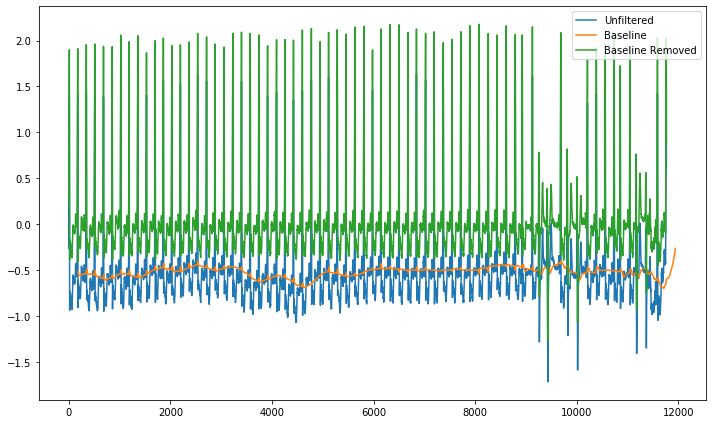

sel31, ch1


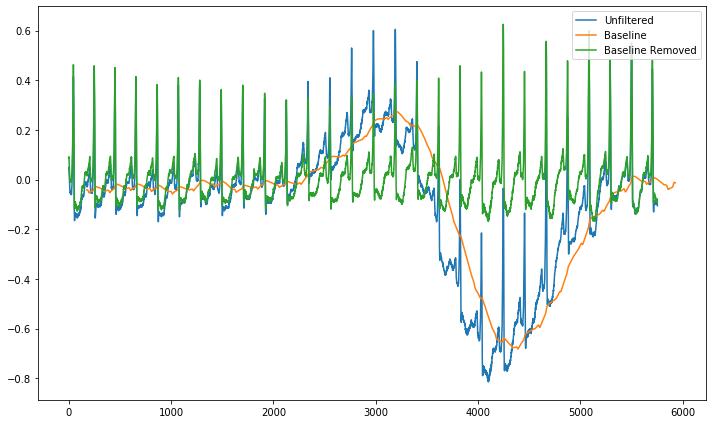

sel39, ch1


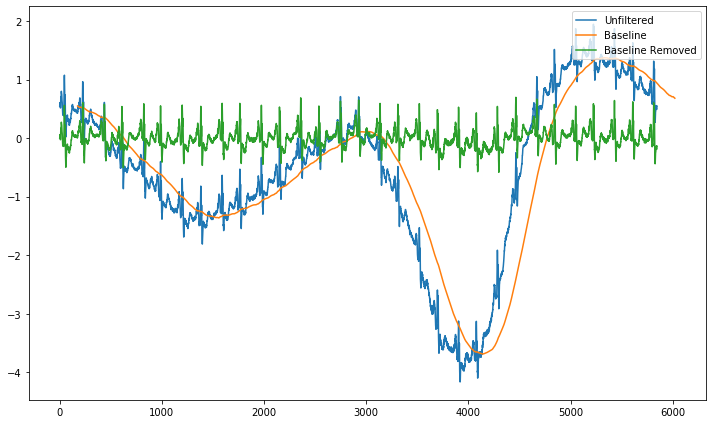

sel117, ch2


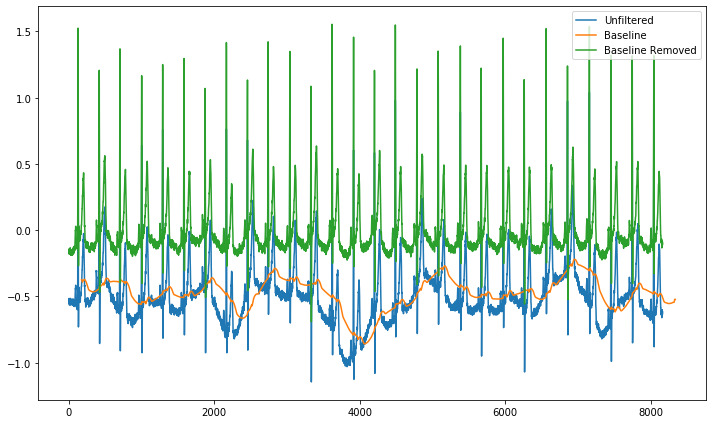

sel123, ch2


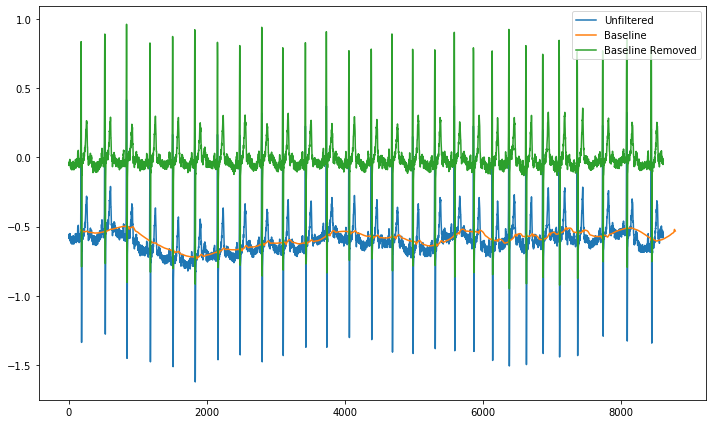

In [6]:
df = df.apply(remove_baseline, channel='ch1', axis=1)
df = df.apply(remove_baseline, channel='ch2', axis=1)
df.to_pickle('data_labels_preprocessed.pkl', protocol=4)

Define a function to calculate the scalogram (ie continuous wavelet transform). Note that the signal is first downsampled from 250Hz to 125Hz as there is not too much frequency information about 60Hz, and this will reduce the computational complexity of the model.

In [7]:
to_plot = {'sel45':'ch1', 'sel50':'ch1', 'sele0170':'ch1', 'sele0409':'ch1'}

def get_scalogram(row, channel):
    data = row[channel]
    record_name = row['record_name']

    #check if the input is None (ie there's no data) in which case return None back
    if data is None:
        row['cwt_' + channel] = None
        return row

    #apply a 60Hz lpf and then downsample from 250Hz to 125Hz
    data = filtfilt(b, 1, data)
    data = data[0::2]
    row[channel] = data

    #do the actual cwt
    wavelet = 'morl'
    scales = np.arange(2,64)  #this corresponds to ~1.5Hz - 50Hz
    coefficients, frequencies = pywt.cwt(data=data, scales=scales, wavelet=wavelet, sampling_period=1/125)

    #now "downsample" the indices of the QRS labels by a factor of two as well
    qrs = row['qrs_' + channel]
    qrs = np.unique((qrs/2).astype(int))
    row['qrs_' + channel] = qrs

    inds_to_keep = row['inds_to_keep_' + channel]
    inds_to_keep = np.unique((inds_to_keep/2).astype(int))
    row['inds_to_keep_' + channel] = inds_to_keep

    power = (abs(coefficients))**2
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    plt.plot(data, label='ECG')
    plt.plot(qrs, data[qrs], label='QRS')
    plt.legend(loc=1)
    ax2 = plt.subplot(212, sharex=ax1)
    plt.contourf(range(len(data)), frequencies, np.log2(power), contourlevels, extend='both', cmap='jet')
    plt.ylabel('Hz')
    plt.xlabel('Time (seconds)')
    plt.tight_layout()
    plt.savefig('cwt/%s_%s.png' % (record_name, channel), dpi=125)
    #only display a selected few results
    if (record_name in to_plot) and (channel==to_plot[record_name]):
        print('%s, %s' % (record_name, channel))
        plt.show()
    plt.close()

    #add the cwt coefficients to the row
    row['cwt_' + channel] = coefficients

    return row


Calculate the scalograms

sel45, ch1


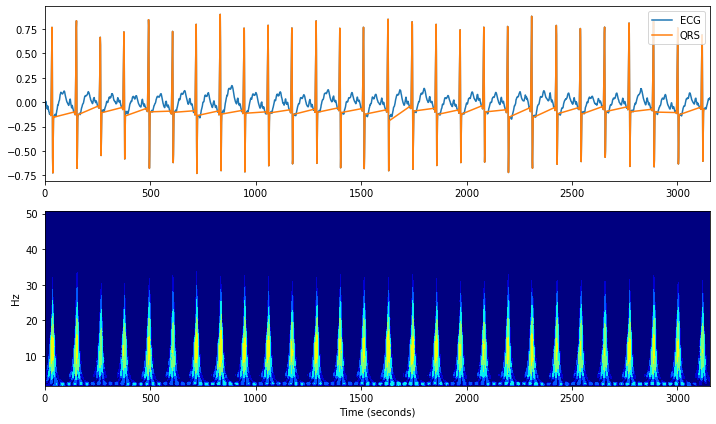

sel50, ch1


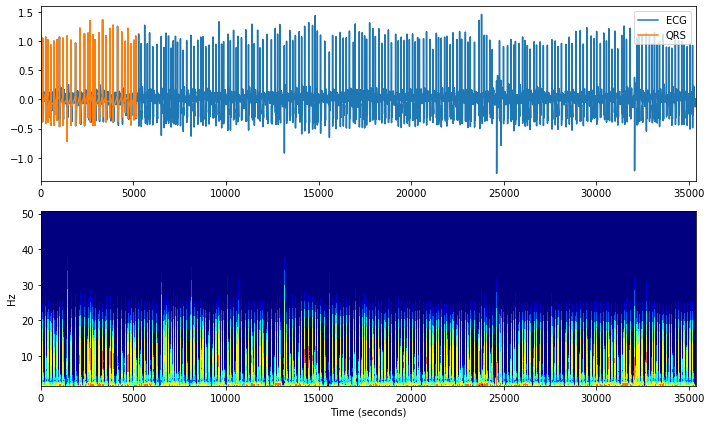

sele0170, ch1


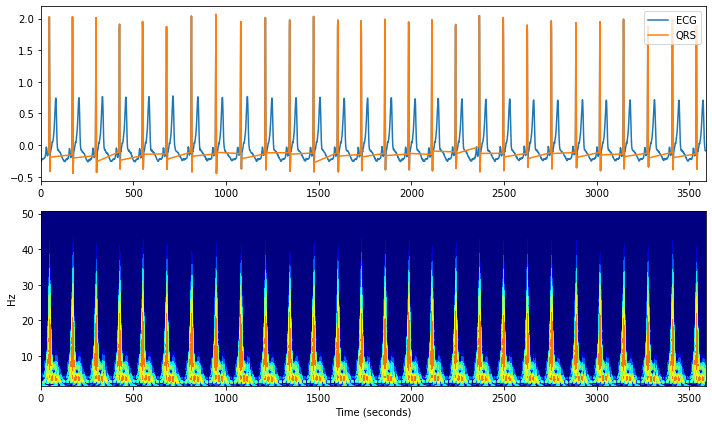

sele0409, ch1


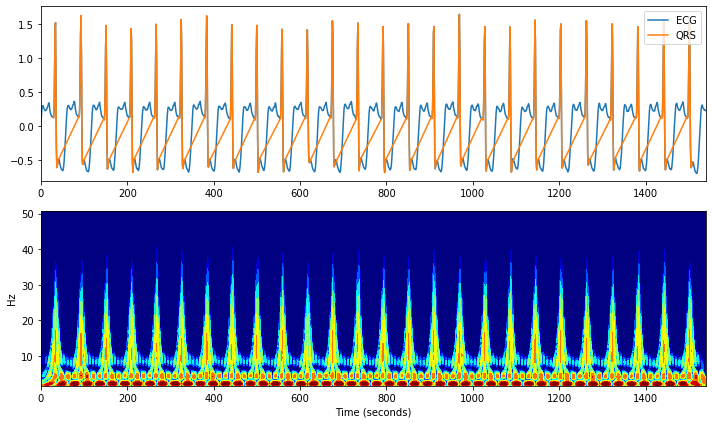

In [8]:
df = df.apply(get_scalogram, channel='ch1', axis=1)
df = df.apply(get_scalogram, channel='ch2', axis=1)
df.to_pickle('data_labels_preprocessed.pkl', protocol=4)